In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D
from tensorflow.keras.models import Model, save_model, load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
ds_name = "synthethic_holograms_ft_ac_complex_amp_phase_v0.nc" # amplitude and phase
# ds_name = "synthethic_holograms_ft_ac_complex_v0.nc" # real and imaginary parts
ds = xr.open_dataset(ds_path+ds_name)  # file with mean (DC) value removed

In [3]:
split_index = 7000
all_labels = ds[["x", "y", "z", "d"]].to_dataframe()
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [4]:
in_data = ds["image_ft"].transpose("hologram_number", "ysize", "xsize","complex") #.expand_dims("channel", 3)

In [5]:
ds["image_ft"].dims

('complex', 'ysize', 'xsize', 'hologram_number')

In [6]:
#ds["image_ft"].max()

In [7]:
scaled_in_data = in_data / 1

In [8]:
conv_input = Input(shape=(400, 600, 2,))  # increase third dimension from 1 to 2 for complex FT data
conv_1 = Conv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)
conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(all_labels.shape[1])(dense_2)  # number of outputs determined by the parameters we are training to
mod = Model(conv_input, out)
mod.compile(optimizer="adam", loss="mae")
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 600, 2)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 600, 8)       408       
_________________________________________________________________
activation (Activation)      (None, 400, 600, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 150, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 150, 16)      3216      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 150, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 37, 16)        0     

In [9]:
mod.fit(scaled_in_data[:split_index].values, scaled_train_labels.values, batch_size=16, epochs=30, verbose=1)

Train on 7000 samples
Epoch 1/30
7000/7000 [==============================] - 128s 18ms/sample - loss: 0.1987
Epoch 2/30
7000/7000 [==============================] - 118s 17ms/sample - loss: 0.1059
Epoch 3/30
7000/7000 [==============================] - 121s 17ms/sample - loss: 0.0546
Epoch 4/30
7000/7000 [==============================] - 120s 17ms/sample - loss: 0.0448
Epoch 5/30
7000/7000 [==============================] - 117s 17ms/sample - loss: 0.0404
Epoch 6/30
7000/7000 [==============================] - 123s 18ms/sample - loss: 0.0367
Epoch 7/30
7000/7000 [==============================] - 119s 17ms/sample - loss: 0.0349
Epoch 8/30
7000/7000 [==============================] - 116s 17ms/sample - loss: 0.0322
Epoch 9/30
7000/7000 [==============================] - 118s 17ms/sample - loss: 0.0307
Epoch 10/30
7000/7000 [==============================] - 119s 17ms/sample - loss: 0.0299
Epoch 11/30
7000/7000 [==============================] - 115s 16ms/sample - loss: 0.0283
Epoch 12

In [10]:
scaled_in_data[:split_index].values.shape

(7000, 400, 600, 2)

In [11]:
# can skip the training process and just load the CNN model
#mod = load_model("holodec_ft_dxyz_cnn.h5")

In [13]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 22.306908 seconds
for 0.0022306908 seconds per hologram


In [14]:
save_model(mod, "holodec_ft_dxyz_"+ds_name.replace(".nc","")+"_cnn.h5", save_format="h5")

In [15]:
preds_original = scaler.inverse_transform(preds_out)

In [16]:
(test_labels.max() - test_labels.min())

x      1770.686768
y      1180.613525
z    143946.109375
d        49.954773
dtype: float32

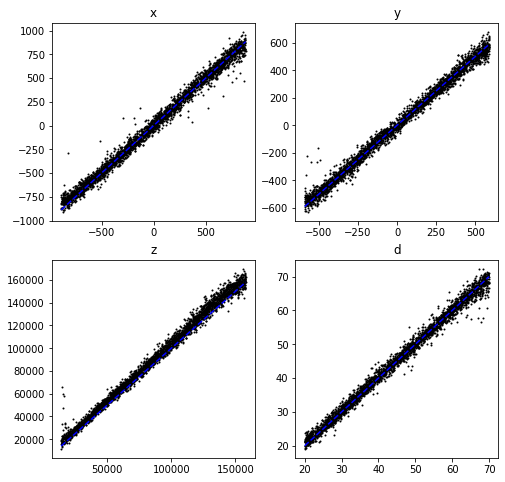

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, ax in enumerate(axes.ravel()):
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
plt.savefig("error_hist_"+ds_name.replace(".nc",".png"), dpi=200, bbox_inches="tight")
    

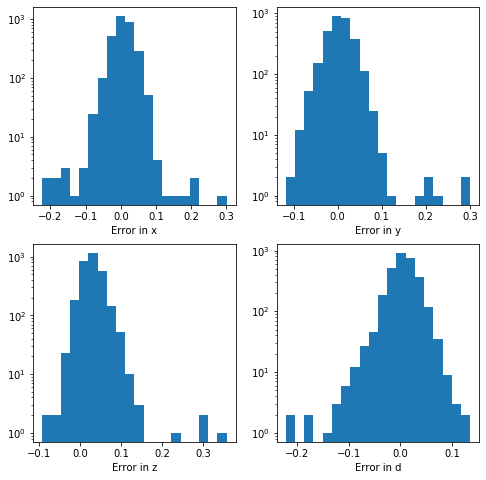

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, ax in enumerate(axes.ravel()):
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+test_labels.columns[a])
plt.savefig("relative_error_histogram_"+ds_name.replace(".nc",".png"), dpi=200, bbox_inches="tight")

In [19]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

array([4.0357525e+01, 2.5892136e+01, 4.6572422e+03, 1.0331846e+00],
      dtype=float32)

In [20]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

array([0.02276821, 0.0219265 , 0.032346  , 0.0206748 ])

In [21]:
test_labels["d"].max()

69.97508

In [22]:
ds["xsize"]

<xarray.DataArray 'xsize' (xsize: 600)>
array([  0,   1,   2, ..., 597, 598, 599])
Dimensions without coordinates: xsize

In [23]:
ds

<xarray.Dataset>
Dimensions:   (complex: 2, hologram_number: 10000, particle: 10000, xsize: 600, ysize: 400)
Coordinates:
  * complex   (complex) object 'real' 'imag'
Dimensions without coordinates: hologram_number, particle, xsize, ysize
Data variables:
    hid       (particle) float32 ...
    d         (particle) float32 60.736183 51.116993 ... 27.087978 25.60561
    x         (particle) float32 718.0053 172.77432 ... -479.08878 -697.4523
    y         (particle) float32 -442.0235 232.13673 ... 86.968666 20.405518
    z         (particle) float32 145526.12 53762.57 ... 100246.72 46914.418
    image     (ysize, xsize, hologram_number) uint8 ...
    image_ft  (complex, ysize, xsize, hologram_number) float32 ...
Attributes:
    DateCreated:           28-Oct-2019
    Nx:                    600.0
    Ny:                    400.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    Dpmin:                 2e-05
    Dpmax:           

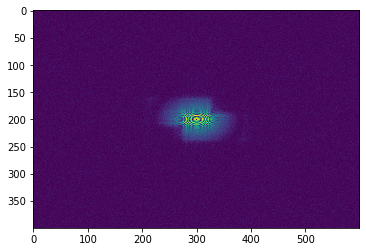

In [27]:
plt.figure()
plt.imshow(ds['image_ft'][0,:,:,5])